# <center>Проект: предсказание токсичности соединений</center>

**<u>Дано:</u>**

* `train.csv` – данные для обучения
* `test_only_smiles.csv` – данные для предсказания

**<u>Необходимо:</u>**

1) Проанализировать данные + визуализация
2) Предобработать данные, чтобы улучшить качество модели
3) Обучить модель и провалидировать ее (метрика: RMSE)
4) Проверить модель на *test* данных и прислать результаты вместе с ноутбуком

## <center>Библиотеки и загрузка данных</center>

In [59]:
import pandas as pd
import numpy as np

In [60]:
train = pd.read_csv("data/train.csv")

In [61]:
train.head()

,SMILES,activity
0,OCC=C,5.0
1,CO/N=C(/C(=O)OC)\C1=C(COC2=C(C)C=CC=C2)C=CC=C1,94.0
2,COC(=O)NS(=O)(=O)C1=CC=C(N)C=C1,5.4
3,CCCCC(CC)C(O)=O,-8.2
4,COC(=O)C1=C(CC(C)C)C(C2=NCCS2)=C(N=C1C(F)F)C(F...,26.2


## <center>Анализ данных</center>

In [62]:
# Посмотрим информацию о датасете
train.info()

# И описательную статистику
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 759 entries, 0 to 758
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMILES    759 non-null    object 
 1   activity  759 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


,activity
count,759.000000
mean,40.691304
std,36.150662
min,-38.300000
25%,10.750000
50%,30.100000
75%,69.550000
max,111.000000


In [63]:
# Избавимся от дубликатов
train_copy = train.copy()
train_copy.drop_duplicates()

,SMILES,activity
0,OCC=C,5.0
1,CO/N=C(/C(=O)OC)\C1=C(COC2=C(C)C=CC=C2)C=CC=C1,94.0
2,COC(=O)NS(=O)(=O)C1=CC=C(N)C=C1,5.4
3,CCCCC(CC)C(O)=O,-8.2
4,COC(=O)C1=C(CC(C)C)C(C2=NCCS2)=C(N=C1C(F)F)C(F...,26.2
...,...,...
754,CC1=CC2=CC=CN=C2C=C1,43.1
755,C12CC[C@@](O)(C#C)[C@@]1(C)CCC3C4CCC(=O)C=C4CCC23,15.8
756,CCCCNS(=O)(=O)C1=CC=CC=C1,17.8
757,NC1=C(Cl)C(Cl)=NC(C(O)=O)=C1Cl,55.1


В нашем датасете всего два столбца:
1) Категориальный признак `SMILES` (тип *object*), содержащий химическую формулу, записанную в текстовом формате.
2) Наш *target* `activity` (тип *float64*), токсичность вещества, которая варьирует от -38.3 до 111.0 в процентах. 

Пропусков и дубликатов в датасете нет.

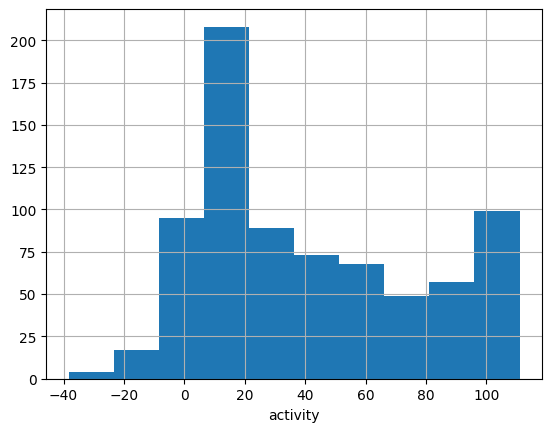

In [64]:
import matplotlib.pyplot as plt

# Визуализация значений 'activity' 
train_copy['activity'].hist()
plt.xlabel('activity')
plt.show()

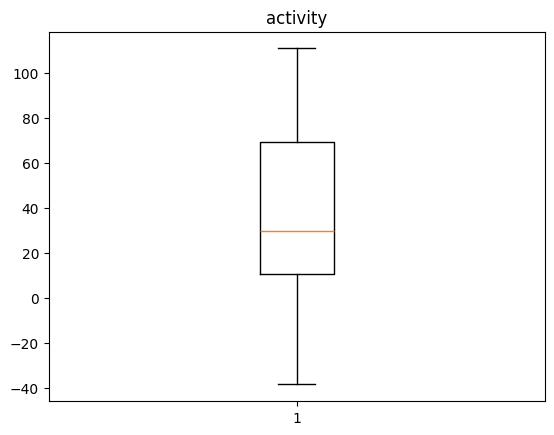

In [65]:
# Boxplot для 'activity'
plt.boxplot(train_copy['activity'])
plt.title('activity')
plt.show()

Визуализация подтверждает информацию, которую мы получили ранее:

* Значения варьируют от -38.3 до 111.0;
* Медиана 30.1.


Также на BoxPlot видно, что нет выбросов.

## <center>Предобработка данных</center>

In [66]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [67]:
# Функция из ноутбука
# Один из способов превратить молекулы в числа – это fingerprints
def smiles_to_fp(smiles):
    '''Convert SMILES to Morgan fingerprints'''
    return np.array([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, nBits=1024) for s in smiles])

In [68]:
X = smiles_to_fp(train_copy.SMILES)

[16:18:59] DEPRECATION WARNING: please use MorganGenerator
[16:18:59] DEPRECATION WARNING: please use MorganGenerator
[16:18:59] DEPRECATION WARNING: please use MorganGenerator
[16:18:59] DEPRECATION WARNING: please use MorganGenerator
[16:18:59] DEPRECATION WARNING: please use MorganGenerator
[16:18:59] DEPRECATION WARNING: please use MorganGenerator
[16:18:59] DEPRECATION WARNING: please use MorganGenerator
[16:18:59] DEPRECATION WARNING: please use MorganGenerator
[16:18:59] DEPRECATION WARNING: please use MorganGenerator
[16:18:59] DEPRECATION WARNING: please use MorganGenerator
[16:18:59] DEPRECATION WARNING: please use MorganGenerator
[16:18:59] DEPRECATION WARNING: please use MorganGenerator
[16:18:59] DEPRECATION WARNING: please use MorganGenerator
[16:18:59] DEPRECATION WARNING: please use MorganGenerator
[16:18:59] DEPRECATION WARNING: please use MorganGenerator
[16:18:59] DEPRECATION WARNING: please use MorganGenerator
[16:18:59] DEPRECATION WARNING: please use MorganGenerat

In [69]:
X.shape

(759, 1024)

In [70]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
X_train, X_valid, y_train, y_valid = train_test_split(X, train['activity'], test_size=0.2, random_state=42)

In [73]:
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_valid.shape, y_valid.shape)

Train: (607, 1024) (607,)
Test: (152, 1024) (152,)


In [74]:
from sklearn.linear_model import LinearRegression

In [75]:
from sklearn import metrics

In [76]:
def linreg(X_train, X_valid, y_train, y_valid):
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    #Делаем предсказание для тренировочной выборки
    y_train_predict = lr_model.predict(X_train)
    #Делаем предсказание для тестовой выборки
    y_valid_predict = lr_model.predict(X_valid)
    
    print("Train RMSE: {:.3f}".format(metrics.root_mean_squared_error(y_train, y_train_predict)))
    print("Valid RMSE: {:.3f}".format(metrics.root_mean_squared_error(y_valid, y_valid_predict)))

In [77]:
from sklearn.decomposition import PCA

In [78]:
def create_pca(X_train, X_valid, components):
    pca = PCA(n_components=components, random_state=42)
    pca.fit(X_train)
    X_train_PCA = pca.transform(X_train)
    X_valid_PCA = pca.transform(X_valid)
    
    return X_train_PCA, X_valid_PCA

In [83]:
linreg(X_train, X_valid, y_train, y_valid)

Train RMSE: 4.645
Valid RMSE: 1495688057864.612


In [84]:
numbers = (8, 16, 32, 64, 128, 256)

for n in numbers:
    print(n)
    X_train_PCA, X_valid_PCA = create_pca(X_train, X_valid, n)
    linreg(X_train_PCA, X_valid_PCA, y_train, y_valid)
    print('-'*10)

8
Train RMSE: 32.533
Valid RMSE: 31.988
----------
16
Train RMSE: 30.346
Valid RMSE: 29.544
----------
32
Train RMSE: 28.090
Valid RMSE: 28.115
----------
64
Train RMSE: 26.104
Valid RMSE: 27.850
----------
128
Train RMSE: 23.387
Valid RMSE: 26.220
----------
256
Train RMSE: 19.023
Valid RMSE: 27.735
----------


In [95]:
numbers = (113,118,123,128,133,138,143)

for n in numbers:
    print(n)
    X_train_PCA, X_valid_PCA = create_pca(X_train, X_valid, n)
    linreg(X_train_PCA, X_valid_PCA, y_train, y_valid)
    print('-'*10)

113
Train RMSE: 23.770
Valid RMSE: 26.288
----------
118
Train RMSE: 23.280
Valid RMSE: 26.694
----------
123
Train RMSE: 23.567
Valid RMSE: 26.449
----------
128
Train RMSE: 23.387
Valid RMSE: 26.220
----------
133
Train RMSE: 23.127
Valid RMSE: 26.556
----------
138
Train RMSE: 23.197
Valid RMSE: 26.682
----------
143
Train RMSE: 23.082
Valid RMSE: 26.418
----------


In [88]:
from sklearn.neighbors import KNeighborsRegressor

In [89]:
def knn_function(X_train, X_valid, y_train, y_valid, n):
    knn_model = KNeighborsRegressor(n_neighbors=n)
    knn_model.fit(X_train, y_train)
    
    #Делаем предсказание для тренировочной выборки
    y_train_predict = knn_model.predict(X_train)
    #Делаем предсказание для тестовой выборки
    y_valid_predict = knn_model.predict(X_valid)
    
    print("Train RMSE: {:.3f}".format(metrics.root_mean_squared_error(y_train, y_train_predict)))
    print("Valid RMSE: {:.3f}".format(metrics.root_mean_squared_error(y_valid, y_valid_predict)))

In [92]:
numbers = (5, 6, 7, 8, 9, 10)

for n in numbers:
    print(n)
    knn_function(X_train, X_valid, y_train, y_valid, n)
    print('-'*10)

5
Train RMSE: 25.624
Valid RMSE: 31.922
----------
6
Train RMSE: 26.729
Valid RMSE: 31.690
----------
7
Train RMSE: 27.705
Valid RMSE: 32.452
----------
8
Train RMSE: 28.307
Valid RMSE: 32.299
----------
9
Train RMSE: 28.793
Valid RMSE: 32.414
----------
10
Train RMSE: 29.178
Valid RMSE: 32.216
----------


In [94]:
numbers = (8, 16, 32, 64, 128, 256)

for n in numbers:
    print(n)
    X_train_PCA, X_valid_PCA = create_pca(X_train, X_valid, n)
    knn_function(X_train_PCA, X_valid_PCA, y_train, y_valid, 5)
    print('-'*10)

8
Train RMSE: 25.564
Valid RMSE: 31.676
----------
16
Train RMSE: 24.462
Valid RMSE: 31.580
----------
32
Train RMSE: 23.878
Valid RMSE: 29.908
----------
64
Train RMSE: 23.595
Valid RMSE: 29.321
----------
128
Train RMSE: 24.087
Valid RMSE: 29.395
----------
256
Train RMSE: 25.274
Valid RMSE: 31.057
----------


In [101]:
test = pd.read_csv("data/test_only_smiles.csv")

In [104]:
test = test[['SMILES']]

test

,SMILES
0,CC(O)CCO
1,CCCCOCCOC(=O)COC1=C(Cl)C=C(Cl)C=C1
2,CO/N=C(/C1=NOCCO1)\C2=C(OC3=NC=NC(OC4=CC=CC=C4...
3,C=CC(=O)NCNC(=O)C=C
4,CC1=CC(=CC=C1)[N+]([O-])=O
...,...
248,OC(=O)/C=C/C1=CC=CC=C1
249,CCOC(=O)C(C)OC(=O)C1=C(C=CC(OC2=C(Cl)C=C(C=C2)...
250,CCO[Si](CCCNC(N)=O)(OCC)OCC
251,ON=C1CCCCC1


In [106]:
X_test = smiles_to_fp(test.SMILES)

[16:53:26] DEPRECATION WARNING: please use MorganGenerator
[16:53:26] DEPRECATION WARNING: please use MorganGenerator
[16:53:26] DEPRECATION WARNING: please use MorganGenerator
[16:53:26] DEPRECATION WARNING: please use MorganGenerator
[16:53:26] DEPRECATION WARNING: please use MorganGenerator
[16:53:26] DEPRECATION WARNING: please use MorganGenerator
[16:53:26] DEPRECATION WARNING: please use MorganGenerator
[16:53:26] DEPRECATION WARNING: please use MorganGenerator
[16:53:26] DEPRECATION WARNING: please use MorganGenerator
[16:53:26] DEPRECATION WARNING: please use MorganGenerator
[16:53:26] DEPRECATION WARNING: please use MorganGenerator
[16:53:26] DEPRECATION WARNING: please use MorganGenerator
[16:53:26] DEPRECATION WARNING: please use MorganGenerator
[16:53:26] DEPRECATION WARNING: please use MorganGenerator
[16:53:26] DEPRECATION WARNING: please use MorganGenerator
[16:53:26] DEPRECATION WARNING: please use MorganGenerator
[16:53:26] DEPRECATION WARNING: please use MorganGenerat

In [107]:
pca = PCA(n_components=128, random_state=42)
pca.fit(X_train)
X_train_PCA = pca.transform(X_train)
X_valid_PCA = pca.transform(X_valid)
X_test_PCA = pca.transform(X_test)

lr_model = LinearRegression()
lr_model.fit(X_train_PCA, y_train)
    
#Делаем предсказание для тренировочной выборки
y_train_predict = lr_model.predict(X_train_PCA)
#Делаем предсказание для тестовой выборки
y_valid_predict = lr_model.predict(X_valid_PCA)
   
print("Train RMSE: {:.3f}".format(metrics.root_mean_squared_error(y_train, y_train_predict)))
print("Valid RMSE: {:.3f}".format(metrics.root_mean_squared_error(y_valid, y_valid_predict)))

Train RMSE: 23.387
Valid RMSE: 26.220


In [108]:
y_test_predict = lr_model.predict(X_test_PCA)

In [109]:
y_test_predict

array([ 12.92560048,  66.97246704,  80.33366632,   9.43276944,
        54.65668654,  36.54595456,  46.58245186,  13.84378074,
        13.23323369,  18.60143107,  25.52894167,  83.06595967,
        24.2026565 ,  13.23047752,  63.84292162,  65.24543078,
         7.59686942,  47.4505092 ,   8.51322789,   3.26041996,
        78.22401041,  25.99661211,  23.18361384,  -5.84283905,
         9.64927258,  24.59456107,  83.02011286,  34.46951089,
         8.95783548,  12.62114786,  57.30684299,  22.7042763 ,
        19.7198689 ,  33.73763921,  49.19212969,  71.85587197,
        17.73734679,  55.75278397,  36.28254349,  11.69169095,
        31.18492162,  15.51161097,  55.5861917 ,  20.94075312,
        30.73236434,  36.27672639,  56.6257919 ,  47.43048171,
        34.70850137,  31.88014441,  75.70075402,  40.55407165,
        58.65646505,  37.42395396,  65.73125875,  26.90542264,
       -10.08293765,  26.53929144,  84.41788079,  30.8329551 ,
       108.79993769,  22.40761599,  21.45192019,  34.58

* Понизить размерность
* Сгенерировать новые признаки
* Попробовать кластеризацию

```python
#Делаем предсказание по признаку LSTAT
y_predict_lstat = lr_lstat.predict(boston_data[['LSTAT']])
#Рассчитываем MAE
print('MAE score: {:.3f} thou. $'.format(metrics.mean_absolute_error(y, y_predict_lstat)))
#Рассчитываем RMSE
print('RMSE score: {:.3f} thou. $'.format(np.sqrt(metrics.mean_squared_error(y, y_predict_lstat))))
```

In [ ]:
#Создаём объект класса линейной регрессии с SGD
sgd_lr_lstat = linear_model.SGDRegressor(random_state=42)

#Обучаем модель — ищем параметры по методу SGD
sgd_lr_lstat.fit(X, y)

print('w0: {}'.format(sgd_lr_lstat.intercept_)) #свободный член w0
print('w1: {}'.format(sgd_lr_lstat.coef_)) #остальные параметры модели w1, w2, ..., wm

In [ ]:
#функция для визуализации регрессии
def plot_regression_2d(X, y_true, y_predict, xlabel='LSTAT', ylabel='MEDV'):
    fig, ax = plt.subplots(figsize=(8, 4)) #фигура + координатная плоскость
    ax.scatter(X, y_true, alpha=0.7, label='Sample data') #диаграмма рассеяния
    ax.plot(X, y_predict, color='black', label='Regression model') #линейный график
    ax.set_xlabel(xlabel) #название оси абсцисс
    ax.set_ylabel(ylabel) #название оси ординат
    ax.legend(facecolor='white', fontsize=11) #легенда

#Предсказываем медианную цену для всех участков из набора данных
y_predict = sgd_lr_lstat.predict(X)
#Строим визуализацию
plot_regression_2d(X, y, y_predict)

* Уточнить finger стандартизирует данные или нет

* Нужна ли регуляризация л1 и л2 (если будет переобучение)

In [ ]:
# загрузим датасет MNIST
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

dataset = fetch_openml("mnist_784")
# загрузим признаки в переменную X  
X = dataset['data']
# загрузим «ответы» в переменную y
y = dataset['target']
# разделим данные с помощью sklearn на данные для обучения и теста
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=0)

# импортируем StandardScaler для стандартизации данных
from sklearn.preprocessing import StandardScaler

# создадим объект класса StandardScaler
scaler = StandardScaler()
scaler.fit(train_x)
# трансформируем датасеты train_x и test_x
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

# импортируем класс PCA
from sklearn.decomposition import PCA

# создадим объект класса PCA
pca = PCA(n_components=300)
pca.fit(train_x)
# уменьшим размерность данных
train_x_pca = pca.transform(train_x)
test_x_pca = pca.transform(test_x)

**Уменьшим размерность с помощью PCA:**

```python
import seaborn as sns

# создадим объект класса PCA, уменьшим размерность данных до 2
pca = PCA(n_components=2, random_state=42)
# уменьшим размерность данных
X_reduced = pca.fit_transform(train_x)
# сохраним данные в датафрейм
df_pca = pd.DataFrame(X_reduced)
# сохраним разметки кластеров
df_pca['c'] = pd.to_numeric(train_y).astype('Int64').to_list()
# визуализируем
sns.scatterplot(x=df_pca[0], y=df_pca[1], c=df_pca['c'])
```

![image.png](https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@dst3-ml4-6_13.png)

```python
‘neg_root_mean_squared_error’

#Итоговый код с использованием функции
#Создаём модель
model = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    max_depth=7, #максимальная глубина
    min_samples_leaf=5, #минимальное число объектов в листе
    random_state=42 #генератор случайных чисел  
)
 
#Создаём объект кросс-валидатора KFold
kf = model_selection.KFold(n_splits=5)
 
#Считаем метрики на кросс-валидации k-fold
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X, #матрица наблюдений X
    y=y, #вектор ответов y
    cv=kf, #кросс-валидатор
    scoring='accuracy', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
display(cv_metrics)
```

```python
print('Train k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean accuracy: {:.2f}'.format(np.mean(cv_metrics['test_score'])))
```

Ключевая идея, заложенная в каждом из методов, звучит так: **снизить переобучение = уменьшить разброс (вариативность) ошибки модели**:

1) **Уменьшение сложности модели**

    * Для **линейной (логистической) регрессии** с полиномиальными признаками уменьшение сложности модели означает понижение степени полинома.
    * Для **деревьев решений** — «стрижка» (*pruning*) деревьев, то есть уменьшение их глубины (`max_depth`) и/или увеличение количества объектов, при которых вершина дерева превращается в лист (`min_samples_leaf`).
    * Для **случайного леса** — «стрижка» деревьев (`max_depth` и `min_samples_leaf`) и уменьшение количества признаков, на которых обучается каждое дерево (`max_features`).

2) **Регуляризация**

    С помощью добавления штрафа в функцию потерь мы намеренно пытаемся увеличить смещение модели, чтобы уменьшить разброс. Закон баланса в действии!

* Нужна ли кривая обучения??

In [ ]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

In [ ]:
plot_learning_curve(
        model, X, y, 
        skf, 
        ax=axes[i], 
        title=model.__class__.__name__ + '()'
)

* Оптимизация параметров

```python
#Создаем список из 20 возможных значений от 0.001 до 10
alpha_list = np.linspace(0.01, 10, 20)
#Создаем пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for alpha in alpha_list:
    #Создаем объект класса линейная регрессия с L2-регуляризацией
    ridge_lr_poly = linear_model.Ridge(alpha=alpha, max_iter=10000)
    #Обучаем модель предсказывать логарифм целевого признака
    ridge_lr_poly.fit(X_train_scaled_poly, y_train_log)
    #Делаем предсказание для каждой из выборок
    #Если обучили на логарифме, то от результата необходимо взять обратную функцию - экспоненту
    y_train_predict_poly = np.exp(ridge_lr_poly.predict(X_train_scaled_poly))
    y_test_predict_poly = np.exp(ridge_lr_poly.predict(X_test_scaled_poly))
    #Рассчитываем метрику для двух выборок и добавляем их в списки
    train_scores.append(metrics.mean_absolute_error(y_train, y_train_predict_poly))
    test_scores.append(metrics.mean_absolute_error(y_test, y_test_predict_poly))
 
#Визуализируем изменение R^2 в зависимости от alpha
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(alpha_list, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(alpha_list, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Alpha') #название оси абсцисс
ax.set_ylabel('MAE') #название оси ординат
ax.set_xticks(alpha_list) #метки по оси абцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды
```